# Introduction
The stock market is known for its volatility and complexity, making it challenging to predict stock prices accurately. However, with the advancements in machine learning, specifically LSTM (Long Short-Term Memory) models, we can leverage historical data to build predictive models and gain insights into future stock price movements. In this report, we explore the use of an LSTM model to predict stock prices and develop a potential trading strategy based on the model's predictions.

# Dataset Description
The dataset used in this analysis is sourced from the HSI (Hang Seng Index) for a specific time frame. It includes historical stock price data, with the 'Close' variable representing the closing price of the HSI index. The dataset covers a specific time period(30-08-2021 to 13-10-2023), providing sufficient historical data for training and testing the LSTM model.

shape of the dataset: (520, 1)


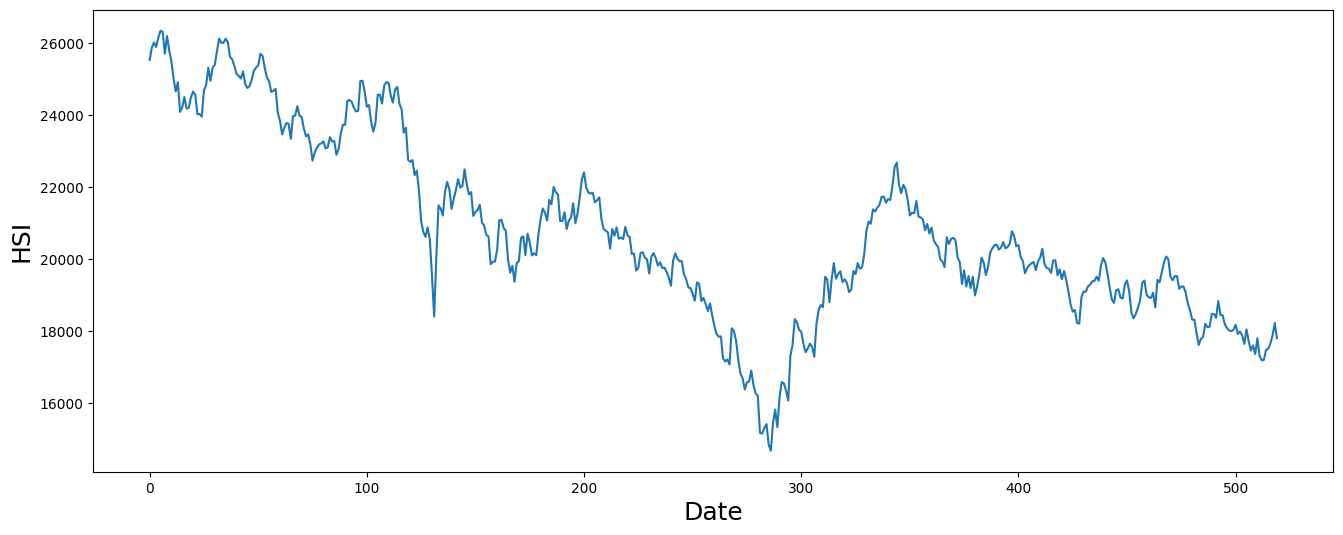

In [1]:
import pandas as pd
import numpy as np
df = pd.read_excel('/kaggle/input/hsi-30082021-13102023/HSI(16810).xlsx')
data = df[['Close']]
data_close = data.values
print("shape of the dataset:",data_close.shape)
#display the data set
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('HSI', fontsize=18)
plt.plot(data['Close'])
plt.show()

# Data Preprocessing
In preparation for the LSTM model, we begin by scaling the dataset to a range of 0 to 1 using the MinMaxScaler from the scikit-learn library. Scaling the data ensures that all features are on a similar scale, which is crucial for the proper functioning of the LSTM model. We then split the dataset into training and testing sets, with 95% of the data allocated for training and 5% reserved for testing. Finally, we create input sequences by dividing the dataset into smaller chunks of data, with each sequence consisting of a fixed window length.

In [2]:
#data preprocessing 
#scale the dataset(0 to 1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_close)


train_size = int(len(scaled_data) * 0.95)  # 95% for training, 5% for testing
train_size

494

In [3]:
#transform the dataset for LSTM input
# Define the length of the input sequences
seq_length = 30

# create sequences
X = []
y = []
for i in range(len(scaled_data) - seq_length):
    X.append(scaled_data[i:i+seq_length])
    y.append(scaled_data[i+seq_length])
X,y = np.array(X),np.array(y)


# Create sequences for training and testing data
X_train = X[:train_size]
y_train = y[:train_size]
X_test  = X[train_size-seq_length:]
y_test  = y[train_size-seq_length:]
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((490, 30, 1), (490, 1), (26, 30, 1), (26, 1))

In [4]:
#define the dataloader for model trainning
import torch
from torch.utils.data import TensorDataset,DataLoader

# Convert train_data to PyTorch Tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test  = torch.Tensor(X_test)
y_test  = torch.Tensor(y_test)
# Create a TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_train, y_train)
# Create a DataLoader for batching and shuffling the data
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# LSTM Model Architecture
The LSTM model used in this analysis consists of an input layer, multiple hidden LSTM layers, and an output layer. The input size is set to 1, representing the number of features used (in this case, the 'Close' price). The hidden size determines the number of LSTM cells in each layer, and the number of layers controls the depth of the LSTM model. The output size is set to 1, representing the predicted stock price.

In [5]:
#define the LSTM model and create the LSTM model instance
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define hyperparameters
input_size = 1
hidden_size = 32
num_layers = 2
output_size = 1

# Create an instance of the LSTM model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Model Training
The LSTM model is trained using the mean squared error (MSE) loss function and the Adam optimizer. We define hyperparameters such as the learning rate, number of epochs, and batch size. During training, the model iterates through the training dataset in batches, updating the model's weights to minimize the loss function. We keep track of the running loss for each epoch and print the training loss to monitor the model's progress.

In [6]:
epochs = 500
batch_size = 32
for epoch in range(epochs):
    running_loss = 0.0
    
    # Iterate over the batches of the training data
    for inputs, labels in train_loader:
        # Clear the previous gradients
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print the training loss for each epoch
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader)}")

Epoch 1/500, Training Loss: 0.04772824529678591
Epoch 2/500, Training Loss: 0.010689839668151352
Epoch 3/500, Training Loss: 0.003186330565386602
Epoch 4/500, Training Loss: 0.0023511851642040475
Epoch 5/500, Training Loss: 0.00212152840779914
Epoch 6/500, Training Loss: 0.0018472506292915392
Epoch 7/500, Training Loss: 0.001750955868872904
Epoch 8/500, Training Loss: 0.0015997346903708193
Epoch 9/500, Training Loss: 0.0019017686079736919
Epoch 10/500, Training Loss: 0.0020367215169713863
Epoch 11/500, Training Loss: 0.0013892098758069257
Epoch 12/500, Training Loss: 0.0011413522654273097
Epoch 13/500, Training Loss: 0.0012558704249620919
Epoch 14/500, Training Loss: 0.001460748245834463
Epoch 15/500, Training Loss: 0.00137616952903749
Epoch 16/500, Training Loss: 0.0013835606129554612
Epoch 17/500, Training Loss: 0.0010538366754659482
Epoch 18/500, Training Loss: 0.0011421218702209093
Epoch 19/500, Training Loss: 0.0011992883829084495
Epoch 20/500, Training Loss: 0.0009631515225215305

# Model Evaluation
To evaluate the performance of the LSTM model, we use the testing dataset. We calculate the MSE (Mean Squared Error) and R^2 (R-squared) score as evaluation metrics. The MSE represents the average squared difference between the predicted and actual stock prices, while the R^2 score measures the proportion of the variance in the dependent variable explained by the model. The evaluation metrics provide insights into the accuracy and reliability of the LSTM model in predicting stock prices. Comparing the LSTM model's performance with a simple Naive model further highlights the superiority of the LSTM model.


In [7]:
model.eval()  # Set the model in evaluation mode

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convert X_test to a tensor and move it to the device

with torch.no_grad():
    predictions = model(X_test_tensor)  # Make predictions using the entire dataset

predictions = predictions.cpu().numpy()  # Move predictions to the CPU and convert to a numpy array
predictions = scaler.inverse_transform(predictions)  # Inverse transform the predictions using the scaler

/tmp/ipykernel_20/138775365.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convert X_test to a tensor and move it to the device


/tmp/ipykernel_20/1715920189.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions
/tmp/ipykernel_20/1715920189.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Naive Predictions'] = test['Close'].shift(1)


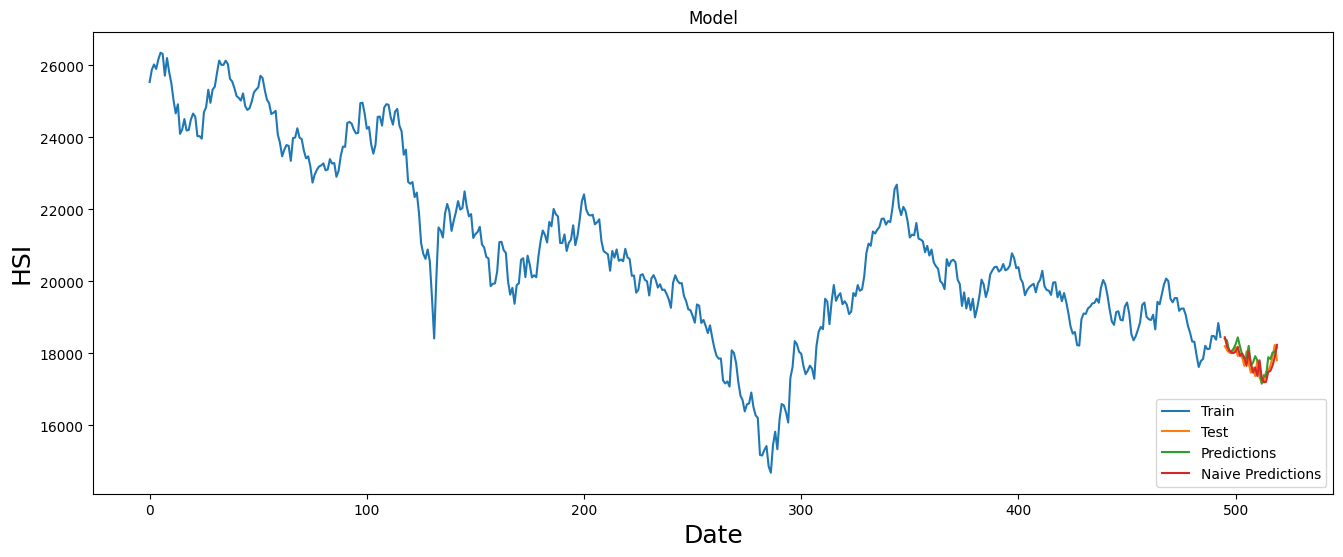

In [8]:

# Plot the data
train = data[:train_size]
test = data[train_size:]
test['Predictions'] = predictions
test['Naive Predictions'] = test['Close'].shift(1)
test = test.dropna()
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('HSI', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions','Naive Predictions']])
plt.legend(['Train', 'Test', 'Predictions','Naive Predictions'], loc='lower right')
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluation(Actual,Preds):
    # Calculate MSE
    mse = mean_squared_error(Actual,Preds)
    print("Mean Squared Error (MSE):", mse)
    # Calculate R^2 score
    r2 = r2_score(Actual,Preds)
    print("R-squared (R^2) Score:", r2)
print("LSTM Predictions:")
evaluation(test['Close'], test['Predictions'])
print("Naive Predictions:")
evaluation(test['Close'], test['Naive Predictions'])

LSTM Predictions:
Mean Squared Error (MSE): 64833.06478950269
R-squared (R^2) Score: 0.31022393060288045
Naive Predictions:
Mean Squared Error (MSE): 61359.403699999886
R-squared (R^2) Score: 0.34718112675756396


# Predictions and Backtesting
Once the model is trained and evaluated, we proceed to make predictions on the testing dataset. We visualize the predicted stock prices alongside the actual prices using a line plot, allowing us to visually compare the model's performance. Additionally, we implement a backtesting strategy based on the model's predictions to simulate a trading scenario. The strategy involves buying or selling positions based on the predicted stock price movements. We calculate the final profit achieved through the backtesting strategy.

In [10]:
import pandas as pd

def backtest(df, initial_cash):
    cash = initial_cash
    shares = 0
    positions = []
    
    for i in range(len(df)):
        if df['Predictions'][i] > df['Close'][i]:  # Buy signal
            if cash > 0:
                shares = cash / df['Close'][i]
                cash = 0
                positions.append(('BUY', df['Close'][i]))
        
        elif df['Predictions'][i] < df['Close'][i]:  # Sell signal
            if shares > 0:
                cash = shares * df['Close'][i]
                shares = 0
                positions.append(('SELL', df['Close'][i]))
    
    # Calculate final profit
    if shares > 0:
        cash = shares * df['Close'].iloc[-1]
    
    profit = cash - initial_cash
    
    return profit, positions

# Call the backtest function with the test dataset and initial cash of 100k
profit, positions = backtest(test.reset_index(), 100000)
print('Backtest on test set:')
print('Final Profit:', profit)
print('Positions:', positions)


Backtest on test set:
Final Profit: 4572.673025007258
Positions: [('BUY', 18202.07), ('SELL', 18057.45), ('BUY', 17729.29), ('SELL', 17809.66), ('BUY', 17331.22), ('SELL', 17195.84), ('BUY', 17213.87), ('SELL', 17485.98), ('BUY', 17517.4), ('SELL', 18238.21), ('BUY', 17813.45)]


# Conclusion
In conclusion, the LSTM model demonstrates its effectiveness in predicting stock prices based on historical data. The evaluation metrics highlight the superior performance of the LSTM model compared to a simple Naive model. However, it is important to note that the LSTM model also has its weaknesses, including a lack of interpretability and the potential for overfitting. Despite these limitations, the LSTM model shows promise in predicting stock prices, and further improvements can be made by refining the model architecture, exploring additional features, and incorporating more advanced trading strategies.
